In [12]:
from sklearn.linear_model import LinearRegression
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib as mpl
import datetime as dt
import pandas as pd
import numpy as np
import os
import datetime
import topf

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 9
mpl.rcParams["axes.titlesize"] = 9
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
ALL_DIR = os.path.join(ROOT_DIR, "data", "All.csv")


In [13]:
def plot_quants_2Dhist(quants, DATA_NTR, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=False, cbar_orientation="vertical", colorvmax=None):

    q0 = DATA_NTR[quants[0]]  # ["Novelty", "Resonance"][0]
    q1 = DATA_NTR[quants[1]]

    q0bins = xbins
    q1bins = ybins

    H, xedges, yedges = np.histogram2d(q0.to_numpy(), q1.to_numpy(), bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value

    # Plot 2D histogram using pcolor
    if colorvmax:
        usemax = colorvmax
    else:
        usemax = H.max()
    pcolm = ax.pcolormesh(xedges, yedges, Hmasked, norm=mpl.colors.LogNorm(vmin=1, vmax=usemax))

    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel("counts")

    ax.set_xlabel(quants[0])
    ax.set_ylabel(quants[1])

    if make_cbar:
        return H, cbar
    else:
        return H

def rvn_plot(source, name, n, x_bin,y_bin):

    fig = plt.figure(figsize=(4.5, 2.5))

    ########################################################## Plot Resonance v. Novelty ##########################################################

    # Formato Eixos
    ax = fig.add_axes([0.7, 0.19, 0.55, 0.65])  # Dist do Y, Dist do X, largura, altura do grafico

    # Formato Cbar
    cbaxes = fig.add_axes([1.18, 0.25, 0.020, 0.15])  # Dist do Y, Dist do X, largura, altura da cbar

    # Colunas
    quants = ["Novelty", "Resonance"]

    # Regressão
    X = source[quants[0]].values.reshape(-1, 1)
    y = source[quants[1]].values.reshape(-1, 1)
    regressor = LinearRegression()
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    slope = regressor.coef_[0][0]
    ax.plot(X, y_pred, color='firebrick', linewidth=1.)
    ax.annotate(f'β = {slope:.3f}', xy=(50, 115), xycoords='axes points',
            size=8, ha='right', va='top', bbox=dict(boxstyle='square', fc='w',linewidth=0.5))

    # Quadrados (bins)

    xbins = np.linspace(2, 10, x_bin)  # Range dos quadrados em X, larguras
    ybins = np.linspace(-3, 3, y_bin)  # Range dos quadrados em Y, alturas

    ## Gerando gráfico
    H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

    # Titulo
    ax.set_title(f"(w = {n})", x=0.5, y=1.05)

    # Linha pontilhada
    #ax.axhline(color="k", linewidth=1.5, linestyle=":")

    # Colorbar
    cbar.ax.set_ylabel("")  # Sem label no Y
    cbar.ax.set_xlabel("")  # Sem label no X
    cbar.ax.yaxis.set_ticks_position("right")  # Posicao ticks
    cbar.ax.tick_params(labelsize=8)  # Tamanho numeros ticks

    # Eixo X
    ax.set_xlabel("Novelty ($\mathcal{N}$)")
    ax.set_xlim(2, 10)  # Escala do eixo X
    ax.set_xticks([2,3, 4, 5, 6, 7, 8, 9,10])  # Numeros de interesse eixo
    ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
    ax.spines["bottom"].set_bounds(2,10)  # Delimita eixo
    ax.spines["top"].set_visible(False)  # Oculta eixo superior

    # Eixo Y
    ax.set_ylabel("Resonance ($\mathcal{R}}$)")
    ax.set_ylim(-3, 3)  # Escala do eixo Y
    ax.set_yticks([-3,-2, -1, 0, 1, 2,3])  # Numeros de interesse eixo
    ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
    ax.spines["left"].set_bounds(-3, 3)  # Delimita eixo
    ax.spines["right"].set_visible(False)  # Oculta eixo direito
    ax.yaxis.set_label_coords(-0.1, 0.5)

    #remove y axis title


    #remove x axis title
    ax.yaxis.label.set_visible(False)
    #set tick numbers invisible
    #set tick labels invisible
    ax.set_yticklabels([])

    return fig


In [14]:
sources = [
    "AP",
    "CBS",
    "CNN",
    "DailyMail",
    "Express",
    "Fox",
    "Guardian",
    "Mirror",
    "NYT",
    "Reuters",
    ]

# for source in sources:
#     data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
#     data_df = data_df.query(f"Source == '{source}'")
#     ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
#     fig = tvn_plot(ntr_df, source, 10, y_bin=50, x_bin=75)
#     fig.savefig(os.path.join(ROOT_DIR, "figures", "2dhist", source + f"_TvN.svg"), format="svg", dpi=1000, bbox_inches="tight")

# sources2 = [
#     "ABC",
#     ]
# for source in sources2:
#     data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
#     data_df = data_df.query(f"Source == '{source}'")
#     ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
#     fig = tvn_plot(ntr_df, source, 10, y_bin=32, x_bin=50)
#     fig.savefig(os.path.join(ROOT_DIR, "figures", "2dhist", source + f"_TvN.svg"), format="svg", dpi=1000, bbox_inches="tight")
    

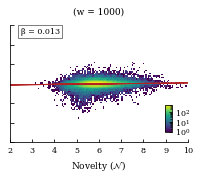

In [15]:
scales = [1000]

for scale in scales:
    data_df = pd.read_csv(os.path.join(ROOT_DIR,"multiscale_results", f"results_{scale}", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
    fig = rvn_plot(ntr_df, "All", scale, y_bin=85, x_bin=135)
    fig.savefig(os.path.join(ROOT_DIR, "figures", "2dhist", f"All_RvN_{scale}.svg"), format="svg", dpi=100, bbox_inches="tight")

In [16]:
def tvn_plot(source, name, n, x_bin,y_bin):

    fig = plt.figure(figsize=(4.5, 2.5))

        ########################################################## Plot Transience v. Novelty ##########################################################

    # Formato Eixos
    ax = fig.add_axes([0, 0.19, 0.4, 0.72])  # Dist do Y, Dist do X, largura, altura do grafico

    # Formato Cbar
    cbaxes = fig.add_axes([0.26, 0.25, 0.020, 0.15])  # Dist do Y, Dist do X, largura, altura da cbar

    # Colunas
    quants = ["Novelty", "Transience"]

    # Quadrados (bins)
    xbins = np.linspace(0, 10, 135)
    ybins = np.linspace(0, 10, 135)

    ## Gerando gráfico
    H, cbar = plot_quants_2Dhist(quants, source, fig, ax, xbins, ybins, make_cbar=True, cbar_axis=cbaxes, cbar_orientation="vertical")

    # Titulo
    ax.set_title(f"(w = {n})", x=0.44, y=0.9)

    # Colorbar
    cbar.ax.set_ylabel("")  # Sem label no Y
    cbar.ax.set_xlabel("")  # Sem label no X
    cbar.ax.yaxis.set_ticks_position("right")  # Posicaoo ticks
    cbar.ax.tick_params(labelsize=8)

    # Linha X=Y
    ax.plot([0, 10], [0, 10], color="firebrick", linewidth=1)

    # Legenda
    # ax.legend([mpl.lines.Line2D([0], [0], color="k", linewidth=1.5, linestyle="--")], ["x=y"], loc="upper center", fontsize=8, ncol=2, handlelength=2.7)

    # Eixo X
    ax.set_xlabel("Novelty $\mathcal{N}$")
    ax.set_xlim(2, 11.5)  # Escala do eixo X
    ax.set_xticks([2, 4, 6, 8, 10])  # Numeros de interesse eixo
    ax.xaxis.set_ticks_position("bottom")  # Ticks embaixo
    ax.spines["bottom"].set_bounds(2, 10)  # Delimita eixo
    ax.spines["top"].set_visible(False)  # Oculta eixo superior
    # ax.tick_params(labelsize=8)
    #move x label slightly left
    ax.xaxis.set_label_coords(0.44, -0.1)

    # Eixo Y
    ax.set_ylabel("Transience $\mathcal{T}$")
    ax.set_ylim(2, 11.5)  # Escala do eixo Y
    ax.set_yticks([2, 4, 6, 8, 10])  # Numeros de interesse eixo
    ax.yaxis.set_ticks_position("left")  # Ticks na esquerda
    ax.spines["left"].set_bounds(2, 10)  # Delimita eixo
    ax.spines["right"].set_visible(False)  # Oculta eixo direito
    # ax.tick_params(labelsize=9)
    ax.yaxis.set_label_coords(-0.1, 0.44)
    return fig




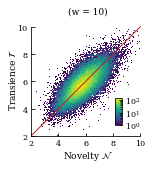

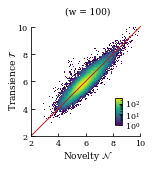

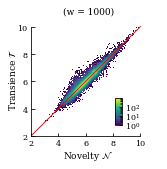

In [17]:
scales = [ 10, 100, 1000]

for scale in scales:
    data_df = pd.read_csv(os.path.join(ROOT_DIR,"multiscale_results", f"results_{scale}", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
    fig = tvn_plot(ntr_df, "All", scale, y_bin=85, x_bin=135)
    fig.savefig(os.path.join(ROOT_DIR, "figures", "2dhist", f"All_TvN_{scale}.svg"), format="svg", dpi=100, bbox_inches="tight")

In [18]:
# add to df distance to peak
def persistent_filter(data_df, limit):
    filtered_df = data_df.loc[:, data_df.max() > limit].copy()
    topics = [int(column.split("_")[1]) for column in filtered_df.columns]
    for topic in topics:
        topic_arr = filtered_df[f"Topic_{topic}"].to_numpy()
        topic_arr_indexed = np.column_stack((np.arange(topic_arr.shape[0]), topic_arr))
        transformer = topf.PersistenceTransformer()  # prepare transformer
        persistence = transformer.fit_transform(topic_arr_indexed)      # transform data into peaks
        peaks = np.copy(persistence)
        threshold = np.max(topic_arr_indexed[:, 1]) / 2
        peaks[peaks[:, 1] < threshold] = 0
        new_cols = {
            f"peaks_{topic}": peaks[:, 1],
        }
        filtered_df = pd.concat([filtered_df, pd.DataFrame(new_cols, index=filtered_df.index)], axis=1)
        filtered_df = filtered_df.drop(f"Topic_{topic}", axis=1)
    dates_dict = {}
    for topic in topics:
        dates_dict[topic] = []
        for i in range(len(filtered_df[f"peaks_{topic}"])):
            if filtered_df[f"peaks_{topic}"][i] != 0:
                dates_dict[topic].append(str(filtered_df.index[i])[:10]) #filtered_df[f"peaks_{topic}"][i], 
    return filtered_df, topics, dates_dict

data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()

results, topics, dates_dict = persistent_filter(data_df,limit=25)

data_df_date = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
df_filtered = data_df_date[data_df_date['Topic'].isin(topics)]

df = df_filtered.copy()

# create a new column in the dataframe to store the smallest distance in days
df["Smallest_Distance"] = 0
# loop over each row in the dataframe
for index, row in df.iterrows():
    # get the topic for the current article
    topic = row["Topic"]
    # get the comparison dates for the current topic
    comp_dates = [datetime.datetime.strptime(d, "%Y-%m-%d").date() for d in dates_dict[topic]]
    # get the publishing date for the current article
    date = index.date()
    # compute smallest distance between the publishing date and comparison dates
    distances = [abs((date - comp_date).days) for comp_date in comp_dates]
    smallest_distance = min(distances)
    # update the "Smallest_Distance" column for the current article
    df.loc[index, "Smallest_Distance"] = smallest_distance

#add dummy variable for smallest distance <=3
df["Peak_dummy_3"] = 0
df["Peak_dummy_0"] = 0
df.loc[df["Smallest_Distance"] <= 3, "Peak_dummy_3"] = 1
df.loc[df["Smallest_Distance"] == 0, "Peak_dummy_0"] = 1

#sort df by smallest distance
df = df.sort_values(by=['Smallest_Distance'], ascending=True)

df1 = df[df["Peak_dummy_3"] == 1]
df2 = df[df["Peak_dummy_3"] == 0]

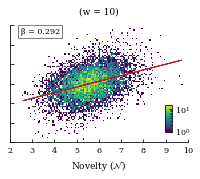

In [19]:
data_df = df1
ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
fig = rvn_plot(ntr_df, "All", 10, y_bin=85, x_bin=135)


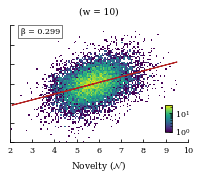

In [20]:
data_df = df2
ntr_df = data_df[["Novelty", "Transience", "Resonance"]].sort_index().loc["2022-01-02":"2022-12-30"].copy()
fig = rvn_plot(ntr_df, "All", 10, y_bin=85, x_bin=135)
